# Assignment 2 | Classification using Convolutional Neural Networks

Student 1 + ID: Bashar Beshoti, 207370248

Student 2 + ID: Selan Abu Saleh, 212111439

### Introduction: 

CNNs have revolutionized the field of computer vision, their unique 
architecture, inspired by the visual cortex, allows CNNs to learn 
intricate patterns in images—detecting edges, textures, and even 
complex features at multiple levels.

 In this assignment we will explore the power of different CNN 
architectures and how to apply them for learning state of the art image 
classification algorithms.

 This assignment is divided into two parts. In the first part, you will 
implement a simple CNN in different ways and compare the 
performance on image classification.
 In the second part, we will use a more powerful network to achieve an 
almost perfect score on a real life dataset.

#### Pre-Tasks : Import Libraries

In [51]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from torchvision import datasets, transforms,models
from tqdm import tqdm
import sklearn

from PIL import Image
from torch.utils.data import Dataset, DataLoader,DataLoader,random_split
from torchsummary import summary
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix



PyTorch check:

In [52]:
# Check if PyTorch is installed
print("PyTorch version:", torch.__version__)

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print("CUDA available:", cuda_available)

# Check the device
device = torch.device("cuda" if cuda_available else "cpu")
print("Device:", device)

# If CUDA is available, print additional information
if cuda_available:
    print("CUDA version:", torch.version.cuda)
    print("Number of CUDA devices:", torch.cuda.device_count())
    print("CUDA device name:", torch.cuda.get_device_name(0))
    print("CUDA device capability:", torch.cuda.get_device_capability(0))

# Check if cuDNN is available
cudnn_available = torch.backends.cudnn.is_available()
print("cuDNN available:", cudnn_available)

# Check the version of cuDNN
if cudnn_available:
    print("cuDNN version:", torch.backends.cudnn.version())

# Check if MPS (Metal Performance Shaders) is available (for macOS)
mps_available = torch.backends.mps.is_available()
print("MPS available:", mps_available)

# Check if MPS is built (for macOS)
mps_built = torch.backends.mps.is_built()
print("MPS built:", mps_built)

PyTorch version: 2.5.1+cpu
CUDA available: False
Device: cpu
cuDNN available: False
MPS available: False
MPS built: False


## Section2: Weather Classification
__Introduction:__ In this task, you’ll explore using a powerful deep learning model for classifying weather conditions based on image data. Weather classification can be valuable in various applications, such as in automated weather monitoring, agricultural planning, and disaster 
response. By leveraging a powerful model that’s known for its effectiveness in image recognition tasks, you’ll gain experience with advanced architectures that achieve high accuracy on real world images.

### The dataset consists of images depicting different weather conditions, each labeled with one of 4 distinct classes: Sunrise, Shine, Cloudy, Rain. Your goal is to train a model to recognize and classify these weather conditions with high accuracy

In [53]:
# Define dataset paths
data_dir = "C:/Users/pc/Desktop/Root/University_Courses/DeepLearning/HW2/data"
train_classes = ["Cloudy", "Rain", "Shine", "Sunrise"]
test_dir = "C:/Users/pc/Desktop/Root/University_Courses/DeepLearning/HW2/data/Test"

# Define class-to-index mapping manually
class_to_idx = {
    "Cloudy": 0,
    "Rain": 1,
    "Shine": 2,
    "Sunrise": 3
}

class TrainingData(Dataset):
    def __init__(self, directory_path, transform=None):
        self.directory_path = directory_path
        self.transform = transform
        self.classes = ['Cloudy', 'Rain', 'Shine', 'Sunrise']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []

        for cls in self.classes:
            cls_folder = os.path.join(directory_path, cls)
            for img_name in os.listdir(cls_folder):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.image_paths.append(os.path.join(cls_folder, img_name))
                    self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

class TestingData(Dataset):
    def __init__(self, directory_path, transform=None):
        self.directory_path = directory_path
        self.transform = transform
        self.classes = ['Cloudy', 'Rain', 'Shine', 'Sunrise']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []

        for img_name in os.listdir(directory_path):
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                self.image_paths.append(os.path.join(directory_path, img_name))
                # Assuming the test images are named in a way that indicates their class
                for cls in self.classes:
                    if cls.lower() in img_name.lower():
                        self.labels.append(self.class_to_idx[cls])
                        break

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


### Task 2.1: Download the train and test datasets from the website. The training data is given in 4 separate zip files due to space constraints in the website, download them and download the test data, preprocess it how you see fit and showcase a couple of images from each of the classes with it’s corresponding label.

In [54]:

# Define the paths
data_dir = 'C:/Users/pc/Desktop/Root/University_Courses/DeepLearning/HW2/data'
train_dir = data_dir
test_dir = os.path.join(data_dir, 'Test')

# Define transformations for the training and testing data
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize datasets
train_dataset = TrainingData(directory_path=train_dir, transform=transform)
test_dataset = TestingData(directory_path=test_dir, transform=transform)

# Define the dataloaders
# Split the train_dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Define the dataloaders
batch_size = 32
train_loader = DataLoader(train_subset, batch_size, shuffle=True)
validation_loader = DataLoader(val_subset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

# Print dataset sizes
print(f'Training dataset size: {len(train_dataset)}')
print(f'Testing dataset size: {len(test_dataset)}')

# Print class to index mapping
print(f'Class to index mapping: {train_dataset.class_to_idx}')


# Verify if the values in both train and test loaders are legal (0 <= value <= classes number - 1)
def verify_loader(loader, num_classes):
    for images, labels in loader:
        if not all(0 <= label < num_classes for label in labels):
            return False
    return True

num_classes = len(train_classes)
train_loader_valid = verify_loader(train_loader, num_classes)
test_loader_valid = verify_loader(test_loader, num_classes)
validation_loader_valid = verify_loader(validation_loader, num_classes)

print(f'Train loader valid: {train_loader_valid}')
print(f'Test loader valid: {test_loader_valid}')
print(f'Validation loader valid: {validation_loader_valid}')


Training dataset size: 1065
Testing dataset size: 60
Class to index mapping: {'Cloudy': 0, 'Rain': 1, 'Shine': 2, 'Sunrise': 3}
Train loader valid: True
Test loader valid: True
Validation loader valid: True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5161401..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.19076979..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5332649..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.45620346..1.6631372].


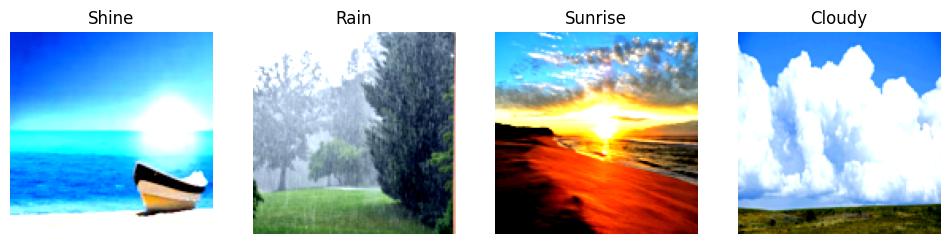

In [55]:
# Function to visualize images with labels
def visualize_samples(data_loader, class_names):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    # Find one sample of each class
    samples = {}
    for img, lbl in zip(images, labels):
        if lbl.item() not in samples:
            samples[lbl.item()] = img
        if len(samples) == len(class_names):
            break

    # Denormalize images
    for lbl in samples:
        samples[lbl] = samples[lbl] * 0.5 + 0.5

    plt.figure(figsize=(12, 6))
    for i, lbl in enumerate(samples):
        plt.subplot(1, len(samples), i + 1)
        plt.imshow(np.transpose(samples[lbl].numpy(), (1, 2, 0)))
        plt.title(class_names[lbl])
        plt.axis("off")
    plt.show()

# Visualize some training images
visualize_samples(train_loader, train_classes)

### Task 2.2: Use any one of the model architectures we talked about in class, load a pre trained version from pytorch and adapt it to classify the 4 weather classes. Fine-tune the model to maximize its performance on the dataset.

We used the ResNet-18 model from torchvision.models because it is a well-known, pre-trained convolutional neural network that performs well on image classification tasks. Here are the key points:

Pre-trained Model: ResNet-18 is pre-trained on a large dataset (ImageNet), which helps in transferring learned features to your specific task, improving performance and reducing training time.
1. Adaptation: You modified the final fully connected layer (model.fc) to output predictions for 4 weather classes instead of the original 1000 classes.
2. Dropout Layer: Added a dropout layer to prevent overfitting.
3. Device Transfer: Moved the model to the appropriate device (CPU or GPU) for efficient computation.
4. Model Summary: Used torchsummary to print a summary of the model architecture, ensuring it is correctly set up for input images of size 128x128 with 3 color channels.

This approach leverages transfer learning to adapt a powerful model to your specific classification task.

### Task 2.2: Use any one of the model architectures we talked about in class, load a pre trained version from pytorch and adapt it to classify the 4 weather classes. Fine-tune the model to maximize its performance on the dataset.

We used the ResNet-18 model from torchvision.models because it is a well-known, pre-trained convolutional neural network that performs well on image classification tasks. Here are the key points:

Pre-trained Model: ResNet-18 is pre-trained on a large dataset (ImageNet), which helps in transferring learned features to your specific task, improving performance and reducing training time.
1. Adaptation: You modified the final fully connected layer (model.fc) to output predictions for 4 weather classes instead of the original 1000 classes.
2. Dropout Layer: Added a dropout layer to prevent overfitting.
3. Device Transfer: Moved the model to the appropriate device (CPU or GPU) for efficient computation.
4. Model Summary: Used torchsummary to print a summary of the model architecture, ensuring it is correctly set up for input images of size 128x128 with 3 color channels.

This approach leverages transfer learning to adapt a powerful model to your specific classification task.

In [56]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
# change the output layer
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, num_classes)
)
model = model.to(device)


C:\Users\pc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\pc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


__Task 2.3: Loss Function__
In class, we showcased different types of loss function, create a 
custom class called:
```py
Class MyLossFunction(*arguments*):
 *write your code here
 ```

Write your custom loss function mathematically using Latex in a text cell above the code cell in the notebook and implement your own custom loss function, you may not use a pre-built loss function from pytorch, even if it’s a regular CE/MSE function.

### Task 2.3: Loss Function

The custom loss function we are using is a smoothed version of the Cross-Entropy Loss. The smoothing technique helps in regularizing the model and preventing overfitting. The mathematical formulation of the loss function is as follows:

Given:
- $\hat{y}_i$ as the predicted probability for class $i$
- $ y_i $ as the one-hot encoded true label for class $i$
- $ \alpha $ as the smoothing parameter
- $ C $ as the number of classes

The smoothed target $y_i^{smooth}$ is calculated as:
$y_i^{smooth} = (1 - \alpha) \cdot y_i + \frac{\alpha}{C}$

The loss function $ L $ is then defined as:
$L = - \sum_{i=1}^{C} y_i^{smooth} \cdot \log(\hat{y}_i)$

#### Explanation:
1. **One-Hot Encoding**: The true labels are converted to one-hot encoded vectors.
2. **Label Smoothing**: The one-hot encoded vectors are smoothed by distributing a small portion of the probability mass to all classes.
3. **Cross-Entropy Calculation**: The loss is calculated by taking the negative log of the predicted probabilities weighted by the smoothed true labels.

The implementation of this loss function in PyTorch is shown in the code cell below.


In [57]:
class MyLossFunction(nn.Module):
    def __init__(self, smoothing=0.1, num_classes=4):
        super(MyLossFunction, self).__init__()
        self.smoothing = smoothing
        self.num_classes = num_classes

    # forward pass of the loss function
    def forward(self, predictions, targets):
        assert targets.min() >= 0 and targets.max() < self.num_classes, \
            f"Targets values should be in the range [0, {self.num_classes - 1}]!"
        
        # convert targets to one-hot encoding 
        targets_one_hot = torch.zeros_like(predictions).scatter_(1, targets.unsqueeze(1), 1)
        # smooth the one-hot encoding
        smooth_targets = (1 - self.smoothing) * targets_one_hot + self.smoothing / self.num_classes
        # calculate the loss
        loss = -smooth_targets * torch.log_softmax(predictions, dim=1)
        return loss.sum(dim=1).mean()

criterion = MyLossFunction(smoothing=0.1, num_classes=len(train_classes))

### Task 2.4: After training the model, evaluate it on the test set. After training the model, evaluate it on the test set.

In [58]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=15):
    train_losses = []
    val_losses = []
    test_accuracies = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = correct / total
        val_losses.append(epoch_loss)
        val_accuracies.append(epoch_acc)

        # Evaluate on the test set
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_acc = correct / total
        test_accuracies.append(test_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, '
              f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}, '
              f'Test Acc: {test_accuracies[-1]:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies, test_accuracies


### Task 2.5: When evaluating on the test set, show a handful of images with their original label and the predicted label.

In [59]:
criterion = MyLossFunction()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Train and validate the model
num_epochs = 20
train_losses,val_losses, train_accuracies, val_accuracies, test_accuracies = train_and_validate(
    model, train_loader, validation_loader, criterion, optimizer, num_epochs
)

Epoch 1/20, Train Loss: 0.7680, Train Acc: 0.8427, Val Loss: 2.0754, Val Acc: 0.7277, Test Acc: 0.7833
Epoch 2/20, Train Loss: 0.5347, Train Acc: 0.9378, Val Loss: 0.4536, Val Acc: 0.9718, Test Acc: 0.9500
Epoch 3/20, Train Loss: 0.4857, Train Acc: 0.9495, Val Loss: 0.4942, Val Acc: 0.9343, Test Acc: 0.9667
Epoch 4/20, Train Loss: 0.4559, Train Acc: 0.9777, Val Loss: 0.4602, Val Acc: 0.9577, Test Acc: 0.9667
Epoch 5/20, Train Loss: 0.4296, Train Acc: 0.9765, Val Loss: 0.4011, Val Acc: 0.9718, Test Acc: 0.9833
Epoch 6/20, Train Loss: 0.4043, Train Acc: 0.9906, Val Loss: 0.5701, Val Acc: 0.9296, Test Acc: 0.9167
Epoch 7/20, Train Loss: 0.4092, Train Acc: 0.9883, Val Loss: 0.4267, Val Acc: 0.9718, Test Acc: 0.9333
Epoch 8/20, Train Loss: 0.3905, Train Acc: 0.9953, Val Loss: 0.4238, Val Acc: 0.9671, Test Acc: 0.9667
Epoch 9/20, Train Loss: 0.4030, Train Acc: 0.9847, Val Loss: 0.3830, Val Acc: 0.9906, Test Acc: 0.9833
Epoch 10/20, Train Loss: 0.4126, Train Acc: 0.9894, Val Loss: 0.4353, Val

### Task 2.6: Also, show the results of the network on the test set using:
 1) test set accuracy percentage (like we always do)
 2) Confusion matrix

 You may use any regularization techniques that you want, the goal is to achieve the highest accuracy that you can.

In [60]:
# Function to plot the metrics
def plot_metrics(train_losses,val_losses, train_accuracies, val_accuracies, test_accuracies, title=''):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 6))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss' + title, color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss' + title, color='purple')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy' + title, color='green')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy'+ title, color='orange')
    plt.plot(epochs, test_accuracies, label='Test Accuracy' + title, color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train, Validation, and Test Accuracy' + title)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to visualize correct and incorrect predictions
def visualize_predictions(model, data_loader, class_names, num_samples=5):
        model.eval()
        correct_samples = []
        incorrect_samples = []

        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                for i in range(len(labels)):
                    if preds[i] == labels[i]:
                        correct_samples.append((inputs[i].cpu(), labels[i].cpu(), preds[i].cpu()))
                    else:
                        incorrect_samples.append((inputs[i].cpu(), labels[i].cpu(), preds[i].cpu()))

                    if len(correct_samples) >= num_samples and len(incorrect_samples) >= num_samples:
                        break
                if len(correct_samples) >= num_samples and len(incorrect_samples) >= num_samples:
                    break

        # Plot correct predictions
        plt.figure(figsize=(9, 3))
        # Plot incorrect predictions
        for i, (img, true_label, pred_label) in enumerate(incorrect_samples[:num_samples]):
            img = img * 0.5 + 0.5  # Denormalize
            plt.subplot(2, num_samples, num_samples + i + 1)
            plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
            plt.title(f'True: {class_names[true_label]}\nPred: {class_names[pred_label]}')
            plt.axis('off')

        for i, (img, true_label, pred_label) in enumerate(correct_samples[:num_samples]):
            img = img * 0.5 + 0.5  # Denormalize
            plt.subplot(2, num_samples, i + 1)
            plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
            plt.title(f'True: {class_names[true_label]}\nPred: {class_names[pred_label]}')
            plt.axis('off')
        

        plt.tight_layout()
        plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(model, data_loader, class_names):
        all_preds = []
        all_labels = []

        model.eval()
        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

Test Set Accuracy: 95.00%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42195398..1.5987669].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.02328968..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.7055321].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55038965..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.31064308..1.7415688].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.5541571..1.82].
Clipp

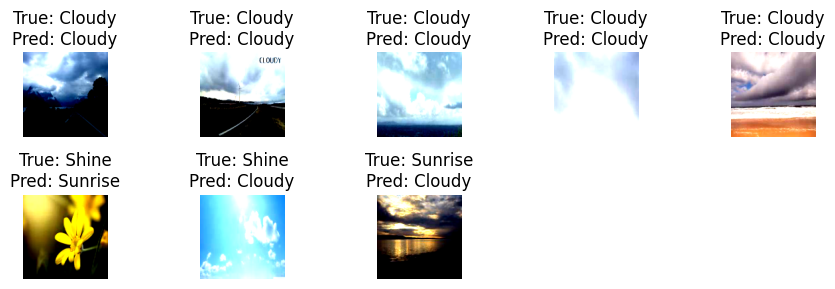

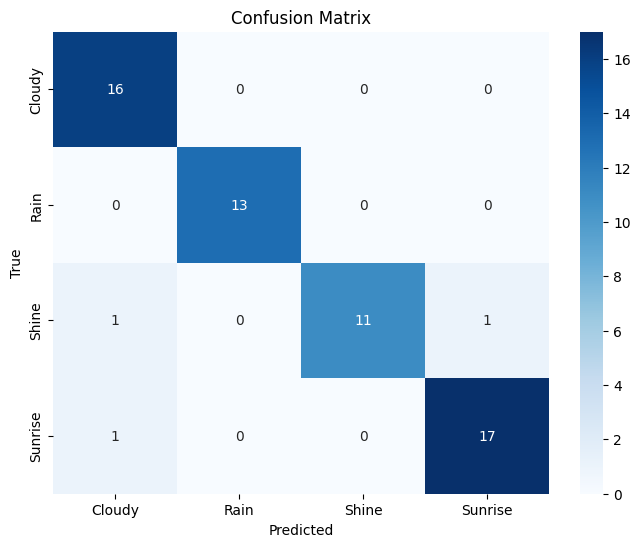

In [61]:
# Calculate test set accuracy percentage
test_accuracy = test_accuracies[-1] * 100
print(f'Test Set Accuracy: {test_accuracy:.2f}%')

# Visualize correct and incorrect predictions
visualize_predictions(model, test_loader, train_classes)

# Plot the confusion matrix for the test set
plot_confusion_matrix(model, test_loader, train_classes)

__Task 2.7:__ Plot the training, validation and testing accuracy as well as the loss function values as a function to the number of epochs.
 The training and validation plots should be showcased in one plot together.

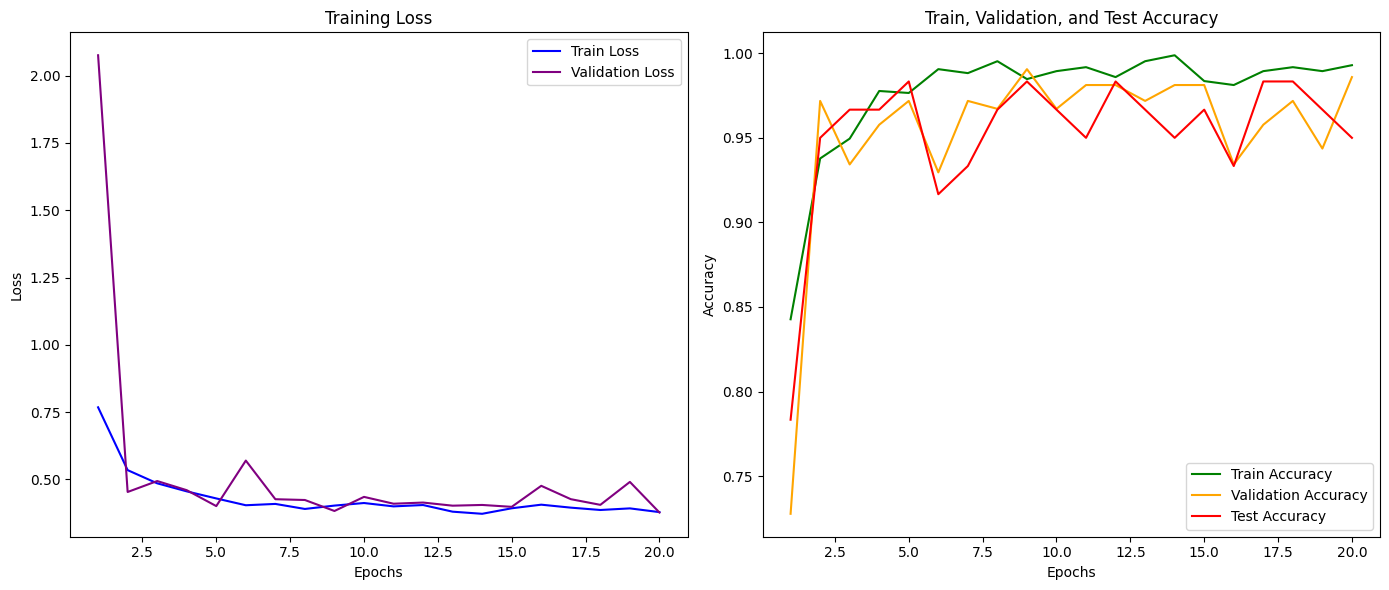

In [62]:
# Plot the metrics
plot_metrics(train_losses,val_losses, train_accuracies, val_accuracies, test_accuracies, '')

## Task 2.8: For the final step, use any projection algorithm we talked about in the class to showcase (visualize) how the model classified the data on a 2D plane.

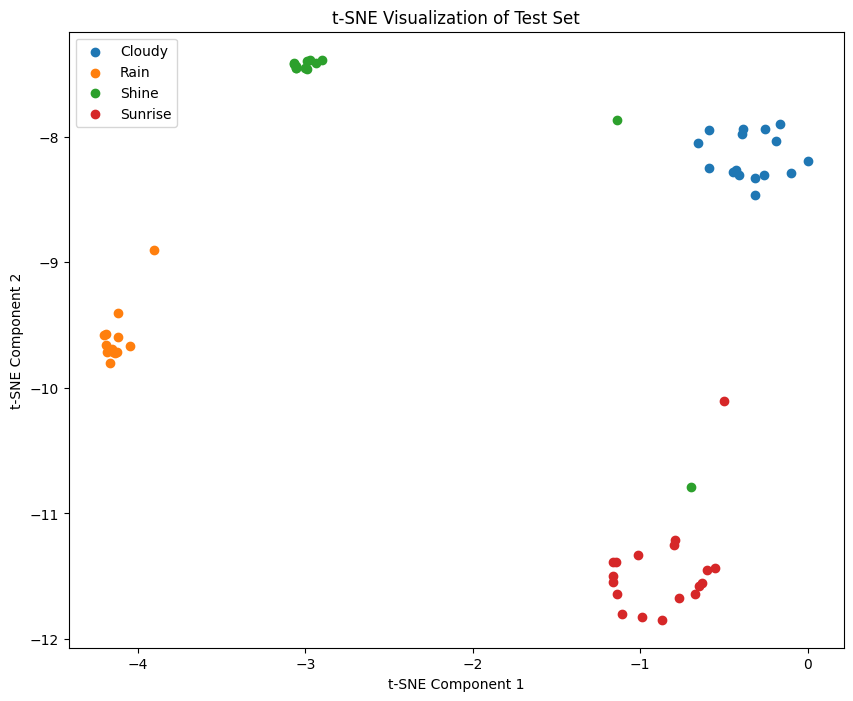

In [63]:
# Function to extract features from the model
def extract_features(model, data_loader):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for inputs, label in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
            labels.append(label.numpy())

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

# Extract features from the test set
test_features, test_labels = extract_features(model, test_loader)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
test_features_2d = tsne.fit_transform(test_features)

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(train_classes):
    indices = test_labels == i
    plt.scatter(test_features_2d[indices, 0], test_features_2d[indices, 1], label=class_name)

plt.legend()
plt.title('t-SNE Visualization of Test Set')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

## Summary

In [67]:
# Print summary of parameters and variables
print(f"Batch size: {batch_size}")
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
print(f"Number of epochs: 20")
print(f"Loss function: Smoothed Cross Entropy Loss")
print(f"Optimizer: Adam")
print(f"Device: {device}")
print(f"Model architecture: ResNet-18")
print(f"Number of classes: {num_classes}")
print(f"number of all model parameters: {sum(p.numel() for p in model.parameters())}")
print(f"number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
# Print the model summary
summary(model, (3, 32, 32))

Batch size: 32
Learning rate: 0.001
Number of epochs: 20
Loss function: Smoothed Cross Entropy Loss
Optimizer: Adam
Device: cpu
Model architecture: ResNet-18
Number of classes: 4
number of all model parameters: 11178564
number of trainable parameters: 11178564
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [

## Submission:
For this assignment, make sure your submission is clear and well organized. You should include a notebook for each part of the assignment with all code cells run and explained.  There’s no need to put the files in a zip file, just submit your 2 `ipynb` files with their names being `HW1_ID1_ID2.ipynb` OR `HW1_ID2_ID1.ipynb`.

- Add text cells to introduce each section, explaining what you did and why. Keep your notebooks tidy and easy to follow, with the names of all group members at the top.

- In each notebook, include comments in your code and use text to describe what you’re doing in each section. Visualize your results with plots that help explain the data and model performance.

- Finally, print each model you use, showing the layer details and the total number of parameters.

- Only the pytorch library can be used as a deep learning tool to work with the models, you can’t use keras or tensorflow under any 
circumstances, you may use other libraries for manipulating the dataset and preprocessing as long as it doesn’t affect the model definition within pytorch.